# Problem 3

In this problem, you will "receive" a stream of samples that you need to demodulate. If you succeed, the decoded message conatins an image that you can view as a reward.

You should use this notebook as the starting point for your work.

This document is fairly long because it contains some code to make your work easier and because I want to make sure that you can see exactly how the transmitter works. You should step through this code before you attempt to demodulate as there are also a few variables and definitions that are set along the way.

In a nut-shell, the received samples encode nearly 200,000 bytes of image data. They are transmitted over multiple burst that are contained in the received samples that you will load into this notebook.

Each burst contains a preamble, a fixed-length header, and a variable length payload. The payload is modulated using one of three possible modulation formats; the header always uses BPSK. The format of the header and functions for reading the header are given below.

There is a variable size gap between consecutive bursts. The channel adds noise and introduces a an amplitude, phase, and frequency shift; the the frequency offset is slowly time-varying.

More details are provided as you read through the notebook.



In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import struct # for header

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Helper functions

The following functions are from notebooks used in class. They should look familiar. Make sure that they have all been "run" so that you can use them for your work.

In [2]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [3]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

This version of the MPE decision rule is slightly different; it returns the index of the best symbol - not the symbol itself

In [4]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    #dec = np.empty_like(Z)
    ind = np.empty_like(Z, dtype=np.uint8)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind[n] = np.argmin(np.abs(A-this_Z))
        # dec[n] = A[ind[n]]

    return ind

### Functions for converting between byte sequences and symbol sequences

The transmitted information is a sequence of bytes. However, transmission occurs in symbols that can carry `bps` bits per symbol.

The following two functions convert between bytes and symbol indices. More precisely, between base $2^8$ for bytes and base $2^{bps}$ for symbols. 

You will see how they are used in both the header and the transmitter.

In [5]:
def bytes_to_symbols(msg, bps):
    """Convert a sequence of bytes to symbols
    
    Inputs:
    msg - a vector of bytes
    bps - bits per symbol
    
    Returns:
    vector of ints (all ints are between 0 and 2**bps - 1)
    
    Note: only works for bps in [1, 2, 4]
    """
    
    syms_per_byte = 8 // bps
    mask = np.uint8(2**bps - 1)
    
    out = np.zeros(syms_per_byte * len(msg), dtype=np.uint8)

    for n in range(len(msg)):
        b = msg[n]
        for m in range(syms_per_byte):
            out[n*syms_per_byte + m] = (b >> (m*bps)) & mask
            
    return out

In [6]:
bytes_to_symbols(b'Hello', 4)

array([ 8,  4,  5,  6, 12,  6, 12,  6, 15,  6], dtype=uint8)

In [7]:
def symbols_to_bytes(syms, bps):
    """Convert a sequence of symbols to bytes
    
    Inputs:
    syms - a vector of bytes
    bps - bits per symbol
    
    Returns:
    vector of uint8 (aka char)
    
    Note: only works for bps in [1, 2, 4]
    """
    syms_per_byte = 8 // bps
    
    msg = np.zeros(len(syms) // syms_per_byte, dtype=np.uint8)
    
    for n in range(len(msg)):
        for m in range(syms_per_byte):
            msg[n] += syms[n*syms_per_byte + m] << (m*bps)
            
    return msg

In [8]:
# round-trip test
symbols_to_bytes( bytes_to_symbols(b'Hello', 4), 4).tobytes()

b'Hello'

## Signal Definitions

We are now ready to dive into the details of the transmitted signal, beginning with the three modulation formats use in the transmitter.

### Constellations

We will use three different constellations: BPSK, QPSK, and 16-QAM. For each, we define a dictionary that shows the mapping of bit-patterns to symbols.

For each of the three constellations, we have:
* a dictionary that shows the mapping from bit-patterns to symbols
* an array that list the symbols in the order indicated by the bit-pattern; e.g., the symbol for `0b0000` (decimal 0) is first, followed by the symbol for `0b0001` (decimal 1).
* an integer that is used as a unique code to refere to the constellation.



In [9]:
BPSK_d = {
    0b0: 1.  + 0j,
    0b1: -1. + 0j
}

# normalized alphabet in order
A_BPSK = np.array([BPSK_d[n] for n in range(2)])

BPSK_MOD_CODE = 0

In [10]:
QPSK_d = {
    0b00:  1. + 1.j,
    0b01: -1. + 1.j,
    0b11: -1. - 1.j,
    0b10:  1. - 1j
}

# normalized alphabet in order
A_QPSK = np.array([QPSK_d[n] for n in range(4)])/np.sqrt(2)

QPSK_MOD_CODE = 1

In [11]:
QAM16_d = {
    0b0000: -3. + 3.j,
    0b0100: -1. + 3.j,
    0b1100:  1. + 3.j,
    0b1000:  3. + 3.j,
    0b0001: -3. + 1.j,
    0b0101: -1. + 1.j,
    0b1101:  1. + 1.j,
    0b1001:  3. + 1.j,
    0b0011: -3. - 1.j,
    0b0111: -1. - 1.j,
    0b1111:  1. - 1.j,
    0b1011:  3. - 1.j,
    0b0010: -3. - 3.j,
    0b0110: -1. - 3.j,
    0b1110:  1. - 3.j,
    0b1010:  3. - 3.j,
}

# normalized alphabet in order
avg_symbol_energy = (4*2 + 8*10 + 4*18)/16
A_QAM16 = np.array([QAM16_d[n] for n in range(16)])/np.sqrt(avg_symbol_energy)

QAM16_MOD_CODE = 2

This dictionary below collects all three modulations into a single table. It is used by the transmitter to look up details of the constellation in use for a given frame. 

The inverse table `rev_mod_table` in particular is useful to translate between numerical `mod_codes` and the constellation names that are keys into the table.

These tables are used by the trasnmitter. You will need them for your receiver as well.

In [12]:
mod_table = {
    'BPSK': {
        'name': 'BPSK',
        'mod_code': BPSK_MOD_CODE,
        'bps': 1,
        'alphabet': A_BPSK,
        'map': BPSK_d,
    },
    'QPSK': {
        'name': 'QPSK',
        'mod_code': QPSK_MOD_CODE,
        'bps': 2,
        'alphabet': A_QPSK,
        'map': QPSK_d,
    },
    'QAM16': {
        'name': '16-QAM',
        'mod_code': QAM16_MOD_CODE,
        'bps': 4,
        'alphabet': A_QAM16,
        'map': QAM16_d,
    }
}

# make an inverse table for looking up names by mod_code
rev_mod_table = {}
for k,v in mod_table.items():
    rev_mod_table[v['mod_code']] = k

### Preamble

The preamble is a known pattern of BPSK symbols. There is not much ealse to say. The preamble pattern is shown below:

In [13]:
preamble_seq = np.array([-1.,  1.,  1.,  1., -1.,  1.,  1., -1., 
                         -1.,  1., -1.,  1., -1., -1., -1.])

### Header 

Information is transmitted in bursts that vary in size and that may be using different modulation formats. To support this feature, the frames contain a *header* that is located between the preamble and the *payload* portion of the burst.

The header is always the same length and it is always BPSK modulated. It contains the following fields:
* `seq`: a sequence number that is incremented from one burst to the next. You can use this to determine if you missed a burst (8-bit unsigned integer, rolls over at 256)
* `mod_code`: an integer that indicates the modulation format for the *payload*. Permitted values are 0, 1, 2 corresponding to the three modulation formats given above, e.g., 0 indicates BPSK. (8-bit unigned integer)
* `pld_n_syms`: number of symbols in the payload. (16-bit unsigned int)

The header always contains 32 bits.

The following two functions, encode and decode the header. Specifically, they translate to and from three integers and an array of 32 bits (stored as uint8).

In [14]:
def encode_hdr(seq, mod_code, pld_n_syms):
    """encode the header
    
    Inputs:
    seq - sequence number
    mod_code - integer indicating modulation for payload
    pld_n_syms - number of symbols in the payload
    
    Returns:
    NumPy array of 32 unsigned 
    
    """
    hdr_bytes = struct.pack('BBH', seq % 256, mod_code, pld_n_syms)
                
    return bytes_to_symbols(hdr_bytes, 1)

In [15]:
# try it out
encode_hdr(1,2,3)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [16]:
def decode_hdr(bit_vec):
    """decode a vector of header bits
    
    Input:
    bit_vec - vector of bits to be decoded
    
    Returns:
    (seq, mod_code, pld_n_syms) tuple
    
    """
    n_bytes = struct.calcsize('BBH')
    assert len(bit_vec) == 8*n_bytes
    
    tmp = symbols_to_bytes(bit_vec, 1)
            
    return struct.unpack('BBH', tmp.tobytes())

In [17]:
# round-trip: encode, then decode
decode_hdr( encode_hdr(12, 1, 12345) )

(12, 1, 12345)

### Transmitter

We now have everything we need to constructs signal bursts (or frames) from a given message of bytes. There are only a few remaining parameters we need to fix.

The received signal is oversampled `fst = 8` times. The transmitter always uses pulse shaping with SRRC pulses with roll-off factor equal to 0.5.

In [18]:
fsT = 8
alpha = 0.5
hh = srrc_pulse(alpha, fsT)

The following function generates transmitted samples from a sequence of bytes. It is the main function of the transmitter and includes both the preamble as well as the header.

If you have any lingering questions, this function should clarify them.

In [19]:
def transmit_burst(msg_bytes, seq, mod_code):
    """generate samples from a sequence of bytes
    
    msg_bytes - a vector of bytes that are to be transmitted
    seq - a sequence number; the frames in the received message are numbered uniquely
    mod_code - the code that indicates how the payload is modulated
    
    Returns:
    A vector of IQ samples
    """
    
    # look up the modulation format
    mod_name = rev_mod_table[mod_code]
    mod_data = mod_table[mod_name]
    A = mod_data['alphabet']
    
    # convert msg_bytes to modulated symbols 
    syms = bytes_to_symbols(msg_bytes, mod_data['bps'])
    mod_syms = A[syms]
    
    # construct the header and turn it into BPSK symbols
    hdr = encode_hdr(seq, mod_code, len(syms))
    mod_hdr = A_BPSK[hdr]
    
    # concatenate preamble, header, and payload
    frame = np.concatenate((preamble_seq, mod_hdr, mod_syms))
    
    # only thing left is pulse shaping
    return pulse_shape(frame, hh, fsT)

### Recovering a burst

The round-trip test below shows that a message can be receovered from transmitted samples. It is not intended to be a working receiver, but it demonstrates that the message bytes can be recovered and how to do so.

In [20]:
# round-trip test - no noise, no nothing
# The transmitted message is just 'Hello'
samples = transmit_burst(b'Hello', 0, 2)

# received starts here
# first, pass signal through a matched filter
mf_out = np.convolve(samples, hh)

# down-sample, as there is no delay we know the right sampling phase
Z = mf_out[len(hh)-1::fsT]

# check that the preamble matches, preamble is 15 symbols long
assert np.abs(np.sum(Z[:15] - preamble_seq)) < 0.1

# then, demod the header - the 32 symbols after the preamble
hdr_Z = Z[15:47]
hdr_syms = MPE_decision_rule(hdr_Z, A_BPSK)
seq, mod_code, pld_len = decode_hdr(hdr_syms)
print("(seq, mod_code, pld_len) = ", seq, mod_code, pld_len)

# now the payload
# we learned how long it is (see pld_len below)
pld_Z = Z[47 : 47+pld_len]
# and how it's modulated (see mod_code below)
# use that to look up pertinent info about the modulation
mod_name = rev_mod_table[mod_code]
mod_data = mod_table[mod_name]
A = mod_data['alphabet']

# hard decision
pld = MPE_decision_rule(pld_Z, A)

# print the decode message
print("Message:", symbols_to_bytes(pld, mod_data['bps']).tobytes())


(seq, mod_code, pld_len) =  0 2 10
Message: b'Hello'


## Load the data

That's it. Now it's time to load the received samples and for you to demodulate them.

You can check that you received all frames by lookin at the sequence numbers. If all works well, you should end up with 187,500 (375 x 500) bytes.

These bytes represent a grayscale image that you can display with the command:
```
plt.imshow(img_seq.reshape(375, 500), cmap='gray', vmax=255)
```
where `img_seq` is the byte sequence that you recovered.

Ok, here is the command to load the samples. The variable `rr` holds the entire sequence of samples - all 7,231,013 of them.

In [21]:
import requests
import io

response = requests.get('https://www.dropbox.com/s/9goxfhnb7esknom/samples_new.npy?dl=1')
response.raise_for_status()
rr = np.load(io.BytesIO(response.content), allow_pickle=True) 


In [22]:
# This should produce:
# array([ 0.00079444+0.02650516j,  0.04401062-0.0330605j ,
#        -0.01314753+0.03902454j, -0.00632757+0.06493751j,
#        -0.06425649-0.01076888j,  0.00895842+0.00556364j,
#        -0.01499228-0.02050581j,  0.04455319+0.02614235j,
#        -0.05121838-0.00267033j, -0.0696573 -0.04798015j])
rr[:10]

array([ 0.00079444+0.02650516j,  0.04401062-0.0330605j ,
       -0.01314753+0.03902454j, -0.00632757+0.06493751j,
       -0.06425649-0.01076888j,  0.00895842+0.00556364j,
       -0.01499228-0.02050581j,  0.04455319+0.02614235j,
       -0.05121838-0.00267033j, -0.0696573 -0.04798015j])

## Receiver

The receiver will work on a sample-by-sample basis; i.e., it consumes one sample at a time and processes.

The receiver is stateful; it cycles through three states:
* SEARCH: the receiver is looking for the preamble. When the preamble is found, amplitude, frequency, and phase is estimated.
* HEADER: the receiver has found the preamble. It demodulates the header portion of the frame and extracts, the sequence number, number of symbols and modulation format.
* DEMOD: the receiver uses the information from the header to demodulate the information symbols. Demodulated symbols are combined into bytes.

During header and payload demodulation, phase is tracked by a PLL that is initialized from the estimates obtained from the preamble.



### PLL

We begin with the implementation of the PLL. In class, we defined objects that represent a second-order loop-filter and an integrator. Those are replicated below.

In [23]:
class Second_Order_Filter():
    """Class representing a second-order loop filter"""

    def __init__(self, alpha1, alpha2, state=0):
        """Initialize the gains and the state of the filter
        
        Input:
        alpha1 - linear gain
        alpha2 - integrator gain
        state - value helpd by integrator (optional, default: 0)
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.state = state

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        out = self.alpha1 * d_n + self.state
        self.state += self.alpha2 * d_n  # update state
        
        return out

    # below, we check that 0 <= alpha2 < alpha1 < 1
    @property
    def alpha1(self):
        return self._alpha1

    @alpha1.setter
    def alpha1(self, new_val):
        if new_val < 1 and new_val > 0:
            self._alpha1 = new_val
        else:
            raise ValueError("alpha1 = {:} can make PLL unstable".format(new_val))

    @property
    def alpha2(self):
        return self._alpha2

    @alpha2.setter
    def alpha2(self, new_val):
        if new_val < self._alpha1 and new_val > 0:
            self._alpha2 = new_val
        else:
            raise ValueError("alpha2 = {:} can make PLL unstable".format(new_val))

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

    @property
    def damping_factor(self):
        return self.alpha1 / 2 / np.sqrt(self.alpha2) 

In [24]:
class Integrator():
    """Class representing an integrator"""

    def __init__(self, state=0):
        self.state = state

    def __call__(self, x_n):
        "Compute the output from the integrator"
        out = self.state
        self.state += x_n

        return out

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

To make the receiver implementation more compact, we encapsulate the loop-filter and the integrator in a PLL class. The PLL class maintains state via these two objects. 

It provides two user visible functions:
* `phase` returns the current phase estimate
* the call operator (`__call__`) takes the phase-rotated, matched filter output and the reference signal as inputs; it measures the phase error and feeds that through the PLL to update the internal state.

In [25]:
class PLL():
    """Class representing a PLL containing a 2nd order loop filter
    
    Parameters:
    alpha1 - alpha1 - linear gain
    alpha2 - integrator gain
    
    Properties:
    freq_offset - estimated freq. offset (state of loop filter)
    phase - estimated current phase offset (state of integrator)
    
    Methods:
    __call(x, x_ref)__ - updates state of PLL 
    
    """
    def __init__(self, alpha1, alpha2):
        # instantiate the loop filter and integrator
        self._H = Second_Order_Filter(alpha1, alpha2, 0.)
        self._I = Integrator(0.)
            
    def __call__(self, x, x_ref):
        """Update PLL state based on phase error
        
        Inputs:
        x - phase-rotated matched filter output
        x_ref - reference signal
        
        Returns:
        phase estimate after update
        """
        # measure phase error
        d_phi = np.angle(x * np.conj(x_ref))
        
        # filter
        y = self._H(d_phi)
        
        # integrate
        self._I(y)
        
        # return phase after update
        return self.phase
    
    @property
    def freq_offset(self):
        # state of 2nd-order loop filter is 2*pi*f_offset
        return self._H.state / (2*np.pi)
    
    @freq_offset.setter
    def freq_offset(self, val):
        self._H.state = 2*np.pi*val
        
    @property
    def phase(self):
        # state of integrator is current phase estimate
        return self._I.state
    
    @phase.setter
    def phase(self, val):
        self._I.state = val
        
        # below, we check that 0 <= alpha2 < alpha1 < 1
    @property
    def alpha1(self):
        return self._H.alpha1

    @alpha1.setter
    def alpha1(self, new_val):
        self._H.alpha1 = new_val

    @property
    def alpha2(self):
        return self._H.alpha2

    @alpha2.setter
    def alpha2(self, new_val):
        self._H.alpha2 = new_val
    

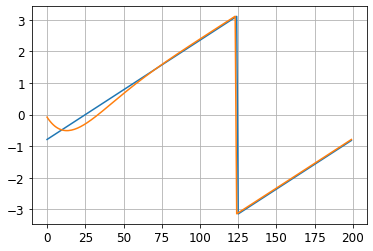

In [43]:
# just making sure this works - track a constant frequency offset
pll = PLL(0.1, 0.004)

N = 200
s = np.exp(1j*(2*np.pi*0.005*np.arange(N) - np.pi/4))
c = np.zeros(N)

for n in range(N):
    c[n] = pll(s[n]*np.exp(-1j*pll.phase), 1)
    
plt.plot(np.angle(s))
plt.plot(np.angle(np.exp(1j*c)))
plt.grid()

plt.show()

### Frequency Estimation

The function for estimating frequency offset is needed by the receiver.

In [56]:
def est_freq(Z, pn, L=None):
    """Estimate frequency estimate from preamble samples

    Inputs:
    Z - matched filter outputs for preamble (taken at symbol period)
    pn - preamble sequence (same length as Z)
    L - spacing between samples to measure phase difference (default 2/3*K)

    Returns:
    float - frequency ofsset per symbol period
    """
    K = len(pn)

    if L is None:
        L = (2*K) // 3

    # make an array of all L-spaced phase differences
    dp = np.array( [ (pn[n+L]*Z[n+L]) * np.conj(pn[n]*Z[n]) for n in range(K-L) ] )

    return np.angle(np.mean(dp))/(2*L*np.pi)

### Receiver

Now, we have everything to implement the Receiver itself. The class below is based on the class from the solution to Homework 6. It adds:

* the PLL from above
* a state for header processing
* instead of returning individual symbols, we collect all symbols for the frame and then convert them to a sequence of bytes. That sequence of bytes is returned for each frame


In [85]:
SEARCH = 1
DEMOD = 2
HEADER = 3

HDR_LEN = 32

class Receiver():
    """class representing a receiver
    
    Parameters:
    fsT - oversmapling factor
    hh - pulse shaping sequence
    pn - preamble sequence
    alpha1, alpha2 - gains for the PLL

    State variables:
    state - either "SEARCH" or "DEMOD" or "HEADER"
    sr_samples - shift register to hold the past len(hh) samples
    sr_mf_out - shift registers for holding len(pn) MF outputs; one per sampling phase
    curr_phase - current sampling phase
    opt_phase - optimal sampling phase
    est_A - estimated amplitude
    
    Additionally, the embedded PLL tracks the estimated phase and frequency offset.

    """

    def __init__(self, fsT, hh, pn, alpha1=0.1, alpha2=0.004):
        # store parameters
        self.fsT = fsT
        self.hh = np.flip(np.conj(hh))
        self.pn = pn
        
        self.pll = PLL(alpha1, alpha2)

        # initialize state
        self.N_h = len(hh)        # length of pulse shaping filter
        self.N_p = len(pn)        # length of preamble sequence
        self.state = SEARCH
        self.sr_samples = np.zeros(self.N_h, dtype=complex)
        self.sr_mf_out = np.zeros((fsT, self.N_p), dtype=complex)
        self.curr_phase = -1
        self.opt_phase = -1
        self.est_A = -1.

        # private state variables
        self._N_sym = 0
        self._detected = False
        self._corr_max = 0
        self._threshold = 0.75
        self._n_demod = 0
        self._A = None
        self._bps = -1
        self._symbols = np.uint8([])

        self._DEBUG = True

    def __call__(self, sample):
        """Process a new sample

        This is the main entry point. Each new sample is matched filtered. Then it is processed according to 
        the current state. 

        If we're still looking for the preamble, then the new sample is combined with other recent samples (stored 
        in self.sr_mf_out) to compute the correlation with the preamble sequence. Once the preamble is found, the state 
        changes to DEMOD.

        In the HEADER and DEMOD states, we only process samples from the correct phase. Phase corrections 
        are applied with the help of the embedded PLL. Amplitude corrections come from the estimated amplitude.
        The MPE decision rule is used to recover symbols.
        
        Any variable that needs to persist between calls, is stored in the object (self.xxx).
        
        Input:
        sample - a single baseband sample

        Returns:
        bytes - if a complete frame of bytes can be output, otherwise None
        """
        res = None # default return value

        # matched filter the new sample and update the sampling phase
        mf_out = self.mf(sample)
        self.curr_phase = (self.curr_phase + 1) % self.fsT

        if self.state == SEARCH:
            ## still looking for the preamble
            corr = self.corr_preamble(mf_out, self.curr_phase)

            # examine the correlation value; 
            if self.found_corr_peak(corr, self.curr_phase):
                # found the correlation peak, perform estimation and update state
                # estimate frequency offset
                est_df = est_freq(self.sr_mf_out[self.opt_phase, :], self.pn)
                # and phasor
                Z_corr = self.sr_mf_out[self.opt_phase, :] * np.exp(-2j * np.pi * est_df * np.arange(self.N_p))
                ZZ_corr_pn = Z_corr * self.pn.conj()
                X_hat = np.sum(ZZ_corr_pn) / np.sum(np.abs(self.pn)**2)

                if self._DEBUG:
                    print("Found preamble on phase {:d}, correlation {:5.3f}".format(self.opt_phase, self._corr_max))
                    print('Estimated frequency offset: {:6.5f} (per T)'.format(est_df))
                    print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))

                # nearly done: just a few more things related to the transition to HEADER
                self.state = HEADER
                # find estimated phasor at beginning of the header
                est_X = X_hat * np.exp(2j*np.pi * est_df * self.N_p)
                self.est_A = np.abs(X_hat)   # estimated amplitude, we're not tracking this 
                # then initialize the PLL
                self.pll.phase = np.angle(est_X)
                self.pll.freq_offset = est_df
                # and prepare for demodulating the header
                self._N_sym = HDR_LEN  # number of symbols in header
                self._A = A_BPSK       # header uses BPSK
                self._symbols = np.zeros(HDR_LEN, dtype=np.uint8) # space to store hdr symbols
                # finally, reset detector variables for next frame
                self._detected = False
                self._corr_max = 0
                self._n_demod = 0
                self.sr_mf_out[:,:] = 0 # don't forget to clear the shift register!
                
        elif self.state == HEADER or self.state == DEMOD:
            # the first part is the same for both states            
            # looking to demod - if we're in the right sampling phase
            if self.curr_phase == self.opt_phase:
                # Compute phase and amplitude correction 
                X_hat = 1/self.est_A * np.exp(-1j*self.pll.phase)
                # apply correction, then decide which symbol was sent
                s = mf_out * X_hat
                dec = np.argmin( np.abs( self._A - s ) ) # hard decision (index of most likely symbol)
                dec_sym = self._A[ dec ]                 # symbol for hard decision
                self._symbols[self._n_demod] = dec       # store hard decision
                
                # update PLL
                self.pll(s, dec_sym)
                 
                # update state and check if we're done
                self._n_demod += 1
                if self._N_sym == self._n_demod:
                    # got all symbols, what happens next depends on the current state
                    if self.state == HEADER:
                        # decode the header
                        seq, mod_code, pld_len = decode_hdr(self._symbols)
                        if self._DEBUG:
                            print('HEADER: seq={:d}, mod_code={:d}, pld_len={:d}'.format(seq, mod_code, pld_len))
                        
                        # prepare for state transition
                        self.state = DEMOD
                        self._N_sym = pld_len               # length of payload
                        self._n_demod = 0
                        try:
                            mod_name = rev_mod_table[mod_code]
                            mod_data = mod_table[mod_name]
                            self._A = mod_data['alphabet']      # constellation of payload
                            self._bps = mod_data['bps']
                            self._symbols = np.zeros(pld_len, dtype=np.uint8)
                        except KeyError:
                            # mod_code is invalid - go back to search
                            self.state = SEARCH
                            print("Error: Invalid header")
                    else:
                        # recover the payload as bytes; we assign the result to `res` so that it gets returned
                        res = symbols_to_bytes(self._symbols, self._bps) #.tobytes()
                        
                        # prepare for state transition
                        self.state = SEARCH
                        if self._DEBUG:
                            print("demodulated {:d} symbols".format(self._n_demod))
                        self._n_demod = 0
            
        else:
            raise ValueError("Invalid State")


        return res

    def mf(self, sample):
        """produce a nw matched filter output"""

        # insert the new sample in the shift register for samples
        self.sr_samples[:self.N_h-1] = self.sr_samples[1:] # lose the oldest sample
        self.sr_samples[-1] = sample                       # insert new sample at end

        # filter (inner product)
        return np.sum(self.hh * self.sr_samples)

    
    def corr_preamble(self, mf_out, phase):
        """Compute correlation agains the preamble sequence"""

        # insert mf_out in the shift register for this sampling phase
        self.sr_mf_out[phase, :self.N_p-1] = self.sr_mf_out[phase, 1:]
        self.sr_mf_out[phase, -1] = mf_out

        # compute correlation; we use the normalized correlation that produces values between 0 and 1
        Num = np.abs( np.sum(self.sr_mf_out[phase, :] * self.pn) )**2
        D1 = np.real( np.sum(self.sr_mf_out[phase, :] * np.conj(self.sr_mf_out[phase, :])) )
        D2 = np.real( np.sum(self.pn * np.conj(self.pn)) )

        return Num / (D1 * D2)

    def found_corr_peak(self, corr, phase):
        """Examine the correlation and update state as needed"""
        found_peak = False

        if corr > self._threshold and not self._detected:
            # this is the first time over the threshold, take note
            self._detected = True
            self._corr_max = corr
            self.opt_phase = self.curr_phase
        elif self._detected:
            # we have been above the threshold recently
            # is this sample bigger than what we had before?
            if corr > self._corr_max:
                self._corr_max = corr
                self.opt_phase = phase
            else:
                # no improvement, let's assume we have seen the correlation peak
                # the opt_phase is whatever was found - no update
                found_peak = True

        return found_peak

In [86]:
# instantiate the receiver
rx = Receiver(fsT, hh, preamble_seq)
rx._DEBUG = False

# then run the receiver over the received samples
ss = np.uint8([])
for n in range(len(rr)):
    pld_bytes = rx(rr[n])
    if pld_bytes is not None:
        # most of the time, the receiver returns `None`, except when we have a frameful of bytes
        ss = np.concatenate((ss, pld_bytes))
        
print("Received {:d} bytes".format(len(ss)))

Received 187500 bytes


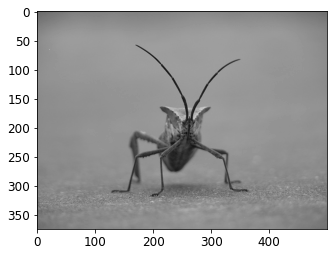

In [87]:
# Let's see what we received
plt.imshow(ss.reshape(375, 500), cmap='gray', vmax=255)
plt.show()